Creating a small dataset of 1000 images

In [ ]:
import os
import json
import random
import shutil

def preparing_data(image_dir, annotation_file, output_dir, annotations_dir, num_images):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    with open(annotation_file, 'r') as f:
        data = json.load(f)

    image_filenames = os.listdir(image_dir)
    selected_images = random.sample(image_filenames, num_images)

    new_data = {
        "info": data.get("info"),
        "categories": data.get("categories"),
        "annotations": [],
        "images": []
    }

    for image_name in selected_images:
        image_id = os.path.splitext(image_name)[0]

        image_data = next((image for image in data["images"] if image["id"] == image_id), None)
        if image_data:
            new_data["images"].append(image_data)

        annotations_for_image = [annotation for annotation in data["annotations"] if annotation["image_id"] == image_id]
        for annotation_data in annotations_for_image:
            new_data["annotations"].append(annotation_data)

    with open(os.path.join(annotations_dir, 'train_data.json'), 'w') as f:
        json.dump(new_data, f, indent=4)

    for image_name in selected_images:
        shutil.copy(os.path.join(image_dir, image_name), output_dir)

    print("Length of images:", len(new_data["images"]))
    print("Length of annotations:", len(new_data["annotations"]))

In [ ]:
if __name__ == "__main__":

    image_dir = "E:\\New_fashion_dataset\\deep_fashion\\images\\val"
    annotation_file = "E:\\New_fashion_dataset\\deep_fashion\\annotations\\instances_val2024.json"
    output_dir = "C:\\Users\\Jeet Vyas\\Untitled Folder 1\\images\\val"
    annotations_dir = "C:\\Users\\Jeet Vyas\\Untitled Folder 1\\annotations"

    preparing_data(image_dir, annotation_file, output_dir , annotations_dir , 1000)

Converting MSCOCO to YOLO form

In [ ]:
import json
import os
import shutil
import yaml

# Function to convert images to YOLO format
def convert_to_yolo(input_images_path, input_json_path, output_images_path, output_labels_path):
    f = open(input_json_path)
    data = json.load(f)
    f.close()

    os.makedirs(output_images_path, exist_ok=True)
    os.makedirs(output_labels_path, exist_ok=True)

    file_names = []
    for filename in os.listdir(input_images_path):
        if filename.endswith(".jpg"):
            source = os.path.join(input_images_path, filename)
            destination = os.path.join(output_images_path, filename)
            shutil.copy(source, destination)
            file_names.append(filename)

    def get_img_ann(image_id):
        return [ann for ann in data['annotations'] if ann['image_id'] == image_id]

    def get_img(filename):
        return next((img for img in data['images'] if img['file_name'] == filename), None)

    for filename in file_names:
        img = get_img(filename)
        img_id = img['id']
        img_w = img['width']
        img_h = img['height']
        img_ann = get_img_ann(img_id)

        if img_ann:
            with open(os.path.join(output_labels_path, f"{os.path.splitext(filename)[0]}.txt"), "a") as file_object:
                for ann in img_ann:
                    current_category = ann['category_id'] - 1
                    polygon = ann['segmentation'][0]
                    normalized_polygon = [format(coord / img_w if i % 2 == 0 else coord / img_h, '.6f') for i, coord in enumerate(polygon)]
                    file_object.write(f"{current_category} " + " ".join(normalized_polygon) + "\n")

In [ ]:
if __name__ == "__main__":
    base_input_path = "EM-platelet-multi/input/"
    base_output_path = "EM-platelet-multi/yolo_dataset/"

    # Processing validation dataset (if needed)
    convert_to_yolo(
        input_images_path=os.path.join(base_input_path, "D:\\dataset\\dataset\\images_input"),
        input_json_path=os.path.join(base_input_path, "D:\\dataset\\dataset\\annotations\\train_data.json"),
        output_images_path=os.path.join(base_output_path, "D:\\dataset\\dataset\\images_output"),
        output_labels_path=os.path.join(base_output_path, "D:\\dataset\\dataset\\labels")
    )


Used Roboflow to create 8:1:1 split and yolov8-seg compatible data

DeepFashion Data YOLOV8-seg model

In [ ]:
!mkdir -p "/content/drive/MyDrive/fashion_data_model"

In [ ]:
folder_path = "/content/drive/MyDrive/fashion_data_model"

In [ ]:
import os

os.chdir(folder_path)

In [ ]:
print(os.getcwd())

/content/drive/MyDrive/fashion_data_model


In [ ]:
!pip install ultralytics

In [ ]:
from ultralytics import YOLO
from matplotlib import pyplot as plt
from PIL import Image

In [ ]:
!pip install roboflow

In [ ]:
model = YOLO('yolov8n-seg.yaml')  # build a new model from YAML
model = YOLO('yolov8n-seg.pt')  # Transfer the weights from a pretrained model (recommended for training)

In [ ]:

from roboflow import Roboflow
rf = Roboflow(api_key="DFgOwZ8kbfFYFwgiMap8")
project = rf.workspace("insynk-vdlo1").project("insynk-itsmv")
version = project.version(1)
dataset = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.1.39, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to Insynk-1 in yolov8:: 100%|██████████| 2011/2011 [00:22<00:00, 90.04it/s]


In [ ]:
%cat /content/drive/MyDrive/fashion_data_model/Insynk-1/data.yaml

names:
- long sleeve dress
- long sleeve outwear
- long sleeve top
- short sleeve dress
- short sleeve top
- shorts
- skirt
- sling
- sling dress
- trousers
- vest
- vest dress
nc: 12
roboflow:
  license: Private
  project: insynk-itsmv
  url: https://app.roboflow.com/insynk-vdlo1/insynk-itsmv/1
  version: 1
  workspace: insynk-vdlo1
test: /content/drive/MyDrive/fashion_data_model/Insynk-1/test/images
train: /content/drive/MyDrive/fashion_data_model/Insynk-1/train/images
val: /content/drive/MyDrive/fashion_data_model/Insynk-1/valid/images


In [ ]:
import yaml
with open("/content/drive/MyDrive/fashion_data_model/Insynk-1/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
#Define a project --> Destination directory for all results
project = "/content/drive/MyDrive/fashion_data_model/Results"
#Define subdirectory for this specific training
name = "20_epochs-"

In [ ]:
import yaml

def train_model_with_config(config_file, data, project, name):

    with open(config_file, 'r') as f:
        config = yaml.safe_load(f)


    epochs = config['epochs']
    patience = config['patience']
    imgsz = config['imgsz']
    batch = config['batch']
    conf = config['conf']
    iou = config['iou']


    results = model.train(data=data,
                          project=project,
                          name=name,
                          epochs=epochs,
                          patience=patience,
                          imgsz=imgsz,
                          batch = batch,
                          conf = conf,
                          iou = iou)

    return results



In [ ]:
%cat /content/drive/MyDrive/fashion_data_model/config.yaml

epochs: 50
patience: 0
batch: 8
imgsz: 640
conf: 0.25
iou : 0.6


In [ ]:
results = train_model_with_config('/content/drive/MyDrive/fashion_data_model/config.yaml',
                                  data='/content/drive/MyDrive/fashion_data_model/Insynk-1/data.yaml',
                                  project=project,
                                  name=name)

Ultralytics YOLOv8.1.39 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=/content/drive/MyDrive/fashion_data_model/Insynk-1/data.yaml, epochs=50, time=None, patience=0, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/fashion_data_model/Results, name=20_epochs-, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=0.25, iou=0.6, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, sav

100%|██████████| 755k/755k [00:00<00:00, 39.2MB/s]


Overriding model.yaml nc=80 with nc=12

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

100%|██████████| 6.23M/6.23M [00:00<00:00, 115MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/fashion_data_model/Insynk-1/train/labels.cache... 800 images, 0 backgrounds, 0 corrupt: 100%|██████████| 800/800 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/fashion_data_model/Insynk-1/valid/labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/fashion_data_model/Results/20_epochs-/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000625, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/fashion_data_model/Results/20_epochs-
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.67G      1.107      3.262      3.735      1.461         31        640: 100%|██████████| 100/100 [03:14<00:00,  1.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.28it/s]

                   all        100        166      0.125    0.00977     0.0679     0.0566      0.125    0.00977     0.0679     0.0424



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.55G        1.1      2.664      3.006       1.42         28        640: 100%|██████████| 100/100 [00:28<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.40it/s]

                   all        100        166      0.213      0.122      0.118     0.0886      0.215      0.125       0.12     0.0845



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.67G       1.08      2.581      2.779      1.408         33        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.28it/s]

                   all        100        166      0.304      0.218      0.253      0.182      0.304      0.218      0.253      0.174



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.55G      1.094      2.698      2.701      1.406         31        640: 100%|██████████| 100/100 [00:28<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]

                   all        100        166      0.278      0.234      0.243      0.177      0.278      0.234      0.243       0.16



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.65G      1.072      2.513      2.612      1.387         30        640: 100%|██████████| 100/100 [00:27<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        100        166      0.245      0.143      0.205      0.144      0.245      0.143      0.205      0.145



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.57G      1.057      2.433      2.486       1.35         37        640: 100%|██████████| 100/100 [00:28<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.28it/s]

                   all        100        166        0.3      0.221      0.261       0.19      0.298      0.219      0.257      0.188



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.53G      1.028      2.439       2.44      1.332         21        640: 100%|██████████| 100/100 [00:28<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        100        166      0.296      0.221      0.249      0.188      0.295      0.219      0.245      0.179



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.53G      1.008      2.411      2.326       1.31         46        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.10it/s]

                   all        100        166      0.287      0.243       0.27      0.214      0.287      0.243       0.27      0.198



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.57G      1.018      2.368       2.29      1.324         35        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.41it/s]

                   all        100        166       0.37      0.215       0.29      0.231      0.367      0.213      0.289      0.208



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.53G     0.9955      2.395      2.247      1.307         35        640: 100%|██████████| 100/100 [00:28<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]


                   all        100        166      0.281      0.207      0.246      0.191      0.281      0.207      0.246      0.176

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.51G     0.9705      2.289      2.189      1.285         33        640: 100%|██████████| 100/100 [00:27<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.23it/s]

                   all        100        166      0.339      0.249      0.298      0.235      0.342       0.25      0.297      0.218



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.55G     0.9535      2.309      2.128      1.286         26        640: 100%|██████████| 100/100 [00:28<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.43it/s]

                   all        100        166      0.344      0.301      0.327      0.258      0.348      0.306       0.33      0.246



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.65G     0.9494       2.29      2.068      1.281         33        640: 100%|██████████| 100/100 [00:27<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.99it/s]


                   all        100        166      0.304      0.296      0.286       0.22      0.305      0.297      0.287      0.204

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.65G      0.929      2.225      2.035      1.269         41        640: 100%|██████████| 100/100 [00:28<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.38it/s]

                   all        100        166      0.337      0.328      0.329      0.252      0.335      0.326      0.327      0.238



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.53G     0.9102      2.194      2.003      1.239         28        640: 100%|██████████| 100/100 [00:27<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.94it/s]

                   all        100        166      0.336       0.32      0.316      0.246      0.339      0.322      0.319      0.231



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.62G     0.9111      2.198      1.938      1.236         29        640: 100%|██████████| 100/100 [00:28<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.53it/s]

                   all        100        166      0.347      0.307      0.324      0.267      0.347      0.307      0.325      0.242



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/50      1.63G     0.9226      2.178      1.947      1.251         40        640: 100%|██████████| 100/100 [00:28<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]

                   all        100        166       0.33      0.265      0.299      0.237       0.33      0.265      0.299      0.222



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.51G      0.888      2.119      1.944      1.229         26        640: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]


                   all        100        166      0.337      0.279      0.311      0.249      0.337      0.279      0.311      0.236

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/50       1.6G     0.8824       2.07      1.841      1.225         34        640: 100%|██████████| 100/100 [00:27<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.35it/s]

                   all        100        166      0.394      0.327      0.348      0.276      0.394      0.327      0.348       0.27



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.62G     0.8762      2.096      1.829      1.221         32        640: 100%|██████████| 100/100 [00:28<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.88it/s]


                   all        100        166      0.336      0.322       0.34      0.267      0.332      0.317      0.335      0.254

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.64G     0.8724      2.082      1.766      1.222         26        640: 100%|██████████| 100/100 [00:27<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.50it/s]

                   all        100        166      0.396       0.31      0.366      0.288      0.397      0.311      0.367       0.28



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.62G     0.8782      2.065      1.772      1.214         28        640: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.46it/s]

                   all        100        166      0.325      0.358      0.361      0.282      0.415      0.362      0.363      0.274



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.63G     0.8465      2.016       1.71        1.2         34        640: 100%|██████████| 100/100 [00:28<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


                   all        100        166      0.398      0.305      0.346      0.265      0.395      0.303      0.343      0.251

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.51G     0.8447      2.005        1.7      1.199         23        640: 100%|██████████| 100/100 [00:27<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.97it/s]

                   all        100        166      0.415      0.403      0.403        0.3      0.413      0.401      0.402      0.289



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.63G     0.8399      1.965      1.637      1.193         25        640: 100%|██████████| 100/100 [00:28<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.30it/s]

                   all        100        166      0.468      0.342      0.352      0.286      0.466       0.34       0.35      0.273



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/50      1.55G     0.8225      1.989      1.631       1.18         33        640: 100%|██████████| 100/100 [00:28<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.26it/s]

                   all        100        166      0.531      0.452       0.49      0.402      0.531      0.453      0.491      0.375



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.65G     0.8111      1.946      1.659      1.175         26        640: 100%|██████████| 100/100 [00:28<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.02it/s]

                   all        100        166      0.414      0.506      0.474      0.386      0.419      0.511      0.481      0.369



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.53G     0.8023      1.902      1.596      1.166         27        640: 100%|██████████| 100/100 [00:27<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.91it/s]

                   all        100        166      0.461      0.361      0.378      0.294      0.461      0.361      0.376      0.284



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/50      1.64G     0.7906      1.913      1.554       1.15         28        640: 100%|██████████| 100/100 [00:28<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.95it/s]

                   all        100        166      0.391      0.387      0.395      0.311      0.389      0.385      0.393      0.277



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.51G     0.7915       1.92      1.545      1.155         30        640: 100%|██████████| 100/100 [00:27<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        100        166      0.379      0.361      0.367        0.3      0.374      0.356      0.364      0.263



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.49G     0.7952      1.882       1.53      1.149         33        640: 100%|██████████| 100/100 [00:28<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.06it/s]

                   all        100        166      0.432      0.403      0.397      0.323       0.43        0.4      0.395      0.287



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.64G      0.746      1.817      1.481      1.135         31        640: 100%|██████████| 100/100 [00:27<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.65it/s]

                   all        100        166      0.484      0.472      0.485      0.394      0.485      0.474      0.487      0.366



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.62G      0.753      1.848      1.426      1.141         34        640: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.19it/s]

                   all        100        166      0.381      0.394      0.404      0.337      0.376      0.389        0.4      0.306



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.65G     0.7595      1.839      1.422      1.138         22        640: 100%|██████████| 100/100 [00:28<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.26it/s]

                   all        100        166      0.381      0.474      0.409      0.348      0.381      0.474      0.409      0.312



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      35/50      1.47G     0.7858      1.856      1.461      1.151         23        640: 100%|██████████| 100/100 [00:28<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]

                   all        100        166      0.368      0.394      0.382      0.314      0.368      0.394      0.381      0.284



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.64G     0.7385      1.791      1.404      1.119         34        640: 100%|██████████| 100/100 [00:27<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.52it/s]

                   all        100        166      0.394      0.479      0.461       0.38      0.392      0.476      0.459      0.348



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      37/50      1.51G     0.7512      1.747      1.403      1.129         33        640: 100%|██████████| 100/100 [00:28<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        100        166      0.347      0.397      0.366      0.294      0.347      0.397      0.365      0.277



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      38/50      1.53G     0.7325       1.75      1.379      1.119         28        640: 100%|██████████| 100/100 [00:27<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.45it/s]

                   all        100        166      0.489      0.332      0.373      0.307      0.489      0.332      0.372      0.285



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      39/50      1.63G     0.7459      1.779      1.334      1.128         32        640: 100%|██████████| 100/100 [00:27<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.17it/s]

                   all        100        166      0.364      0.452      0.399      0.328      0.364      0.452      0.399      0.303



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      40/50      1.64G     0.7139      1.756      1.335      1.114         39        640: 100%|██████████| 100/100 [00:27<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.46it/s]

                   all        100        166      0.374      0.364      0.358      0.302      0.376      0.362      0.357      0.283


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      41/50      1.61G     0.7045      1.672      1.211      1.151         16        640: 100%|██████████| 100/100 [00:27<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.46it/s]

                   all        100        166      0.388      0.448      0.392      0.314      0.386      0.446       0.39      0.303



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      42/50      1.61G     0.6545      1.591      1.087      1.125         13        640: 100%|██████████| 100/100 [00:25<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        100        166      0.358      0.401       0.37      0.303      0.356      0.399      0.368      0.279



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      43/50      1.61G     0.6557      1.544      1.053      1.136         13        640: 100%|██████████| 100/100 [00:26<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.14it/s]

                   all        100        166      0.381      0.503      0.415      0.341      0.379        0.5      0.414      0.313



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      44/50       1.6G     0.6274      1.493      1.011      1.105         15        640: 100%|██████████| 100/100 [00:26<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.14it/s]


                   all        100        166      0.424      0.434      0.453      0.375      0.422      0.432      0.451      0.353

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      45/50      1.61G     0.6143      1.513     0.9712      1.097         15        640: 100%|██████████| 100/100 [00:25<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.51it/s]

                   all        100        166      0.375      0.487      0.422      0.355      0.378       0.49      0.423      0.333



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      46/50      1.61G     0.6165      1.487      0.945      1.094         14        640: 100%|██████████| 100/100 [00:25<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        100        166      0.378      0.497      0.414      0.346      0.379      0.498      0.415      0.314



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      47/50      1.47G     0.6246      1.468     0.9429      1.101         14        640: 100%|██████████| 100/100 [00:25<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]

                   all        100        166      0.418       0.42      0.402      0.345      0.422      0.427      0.405      0.315



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      48/50      1.47G     0.5977       1.42     0.9171      1.074         15        640: 100%|██████████| 100/100 [00:25<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.74it/s]

                   all        100        166      0.387      0.512      0.478      0.412       0.39      0.514      0.478      0.367



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      49/50       1.6G     0.5884      1.421     0.9135      1.076         13        640: 100%|██████████| 100/100 [00:25<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]

                   all        100        166      0.446      0.484      0.489      0.421      0.444      0.482      0.487      0.374



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      50/50      1.47G     0.5905      1.413     0.8989       1.08         13        640: 100%|██████████| 100/100 [00:25<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.19it/s]

                   all        100        166      0.421      0.425      0.425       0.36      0.418      0.423      0.422      0.328



50 epochs completed in 0.469 hours.
Optimizer stripped from /content/drive/MyDrive/fashion_data_model/Results/20_epochs-/weights/last.pt, 6.8MB
Optimizer stripped from /content/drive/MyDrive/fashion_data_model/Results/20_epochs-/weights/best.pt, 6.8MB

Validating /content/drive/MyDrive/fashion_data_model/Results/20_epochs-/weights/best.pt...
Ultralytics YOLOv8.1.39 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-seg summary (fused): 195 layers, 3260404 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.16it/s]


                   all        100        166      0.445      0.484      0.487       0.42      0.443      0.482      0.484      0.373
     long sleeve dress        100          1        0.5          1      0.995      0.995        0.5          1      0.995      0.796
   long sleeve outwear        100          6       0.25      0.167       0.16      0.112       0.25      0.167       0.16     0.0957
       long sleeve top        100         19      0.605      0.684      0.592       0.45      0.605      0.684      0.592      0.457
    short sleeve dress        100         11      0.222      0.273      0.347      0.293      0.222      0.273      0.347      0.296
      short sleeve top        100         38      0.669      0.737      0.772      0.676      0.645      0.711      0.739      0.574
                shorts        100         17      0.717      0.745      0.788      0.648      0.717      0.745      0.788      0.625
                 skirt        100         14      0.307      0.413   

In [ ]:
from IPython.display import Image

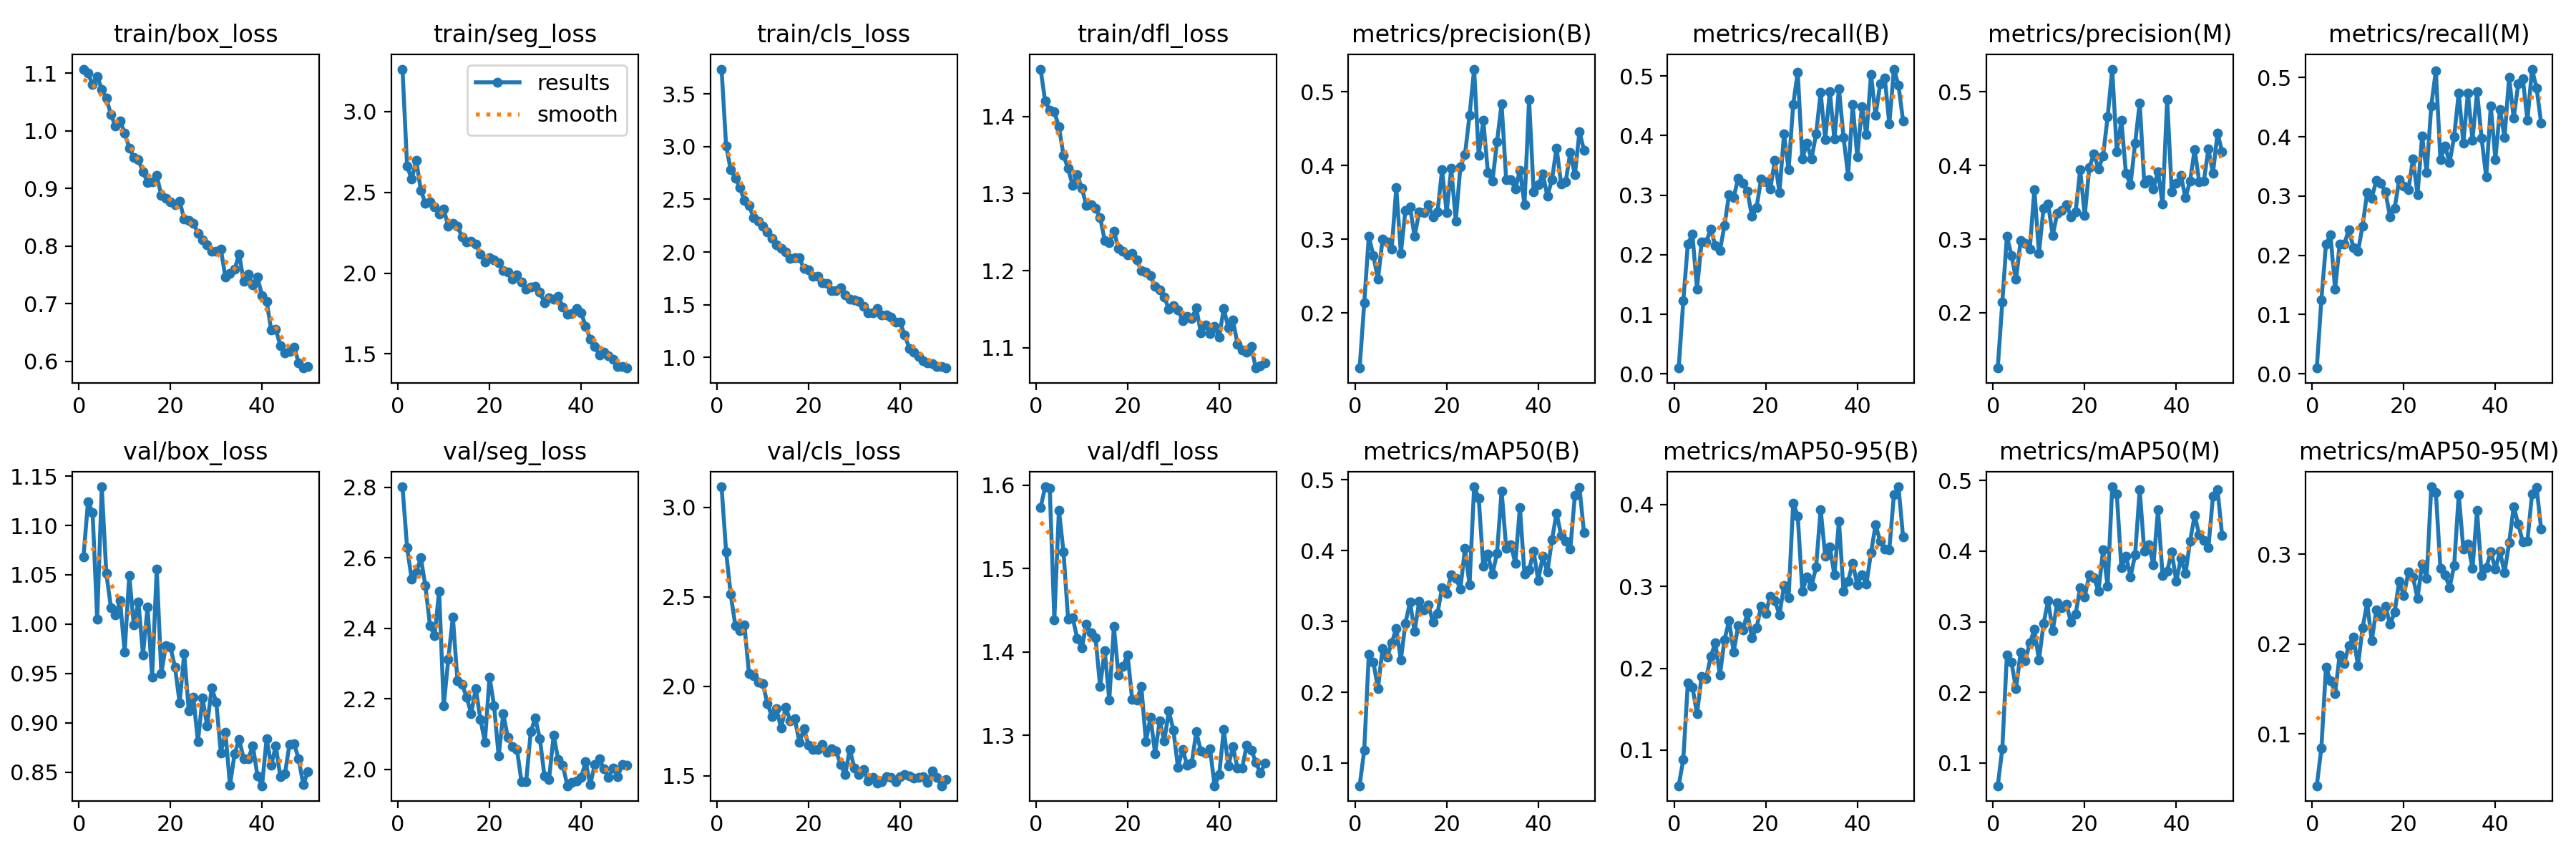

In [ ]:
Image("/content/drive/MyDrive/fashion_data_model/Results/20_epochs-/results.png")

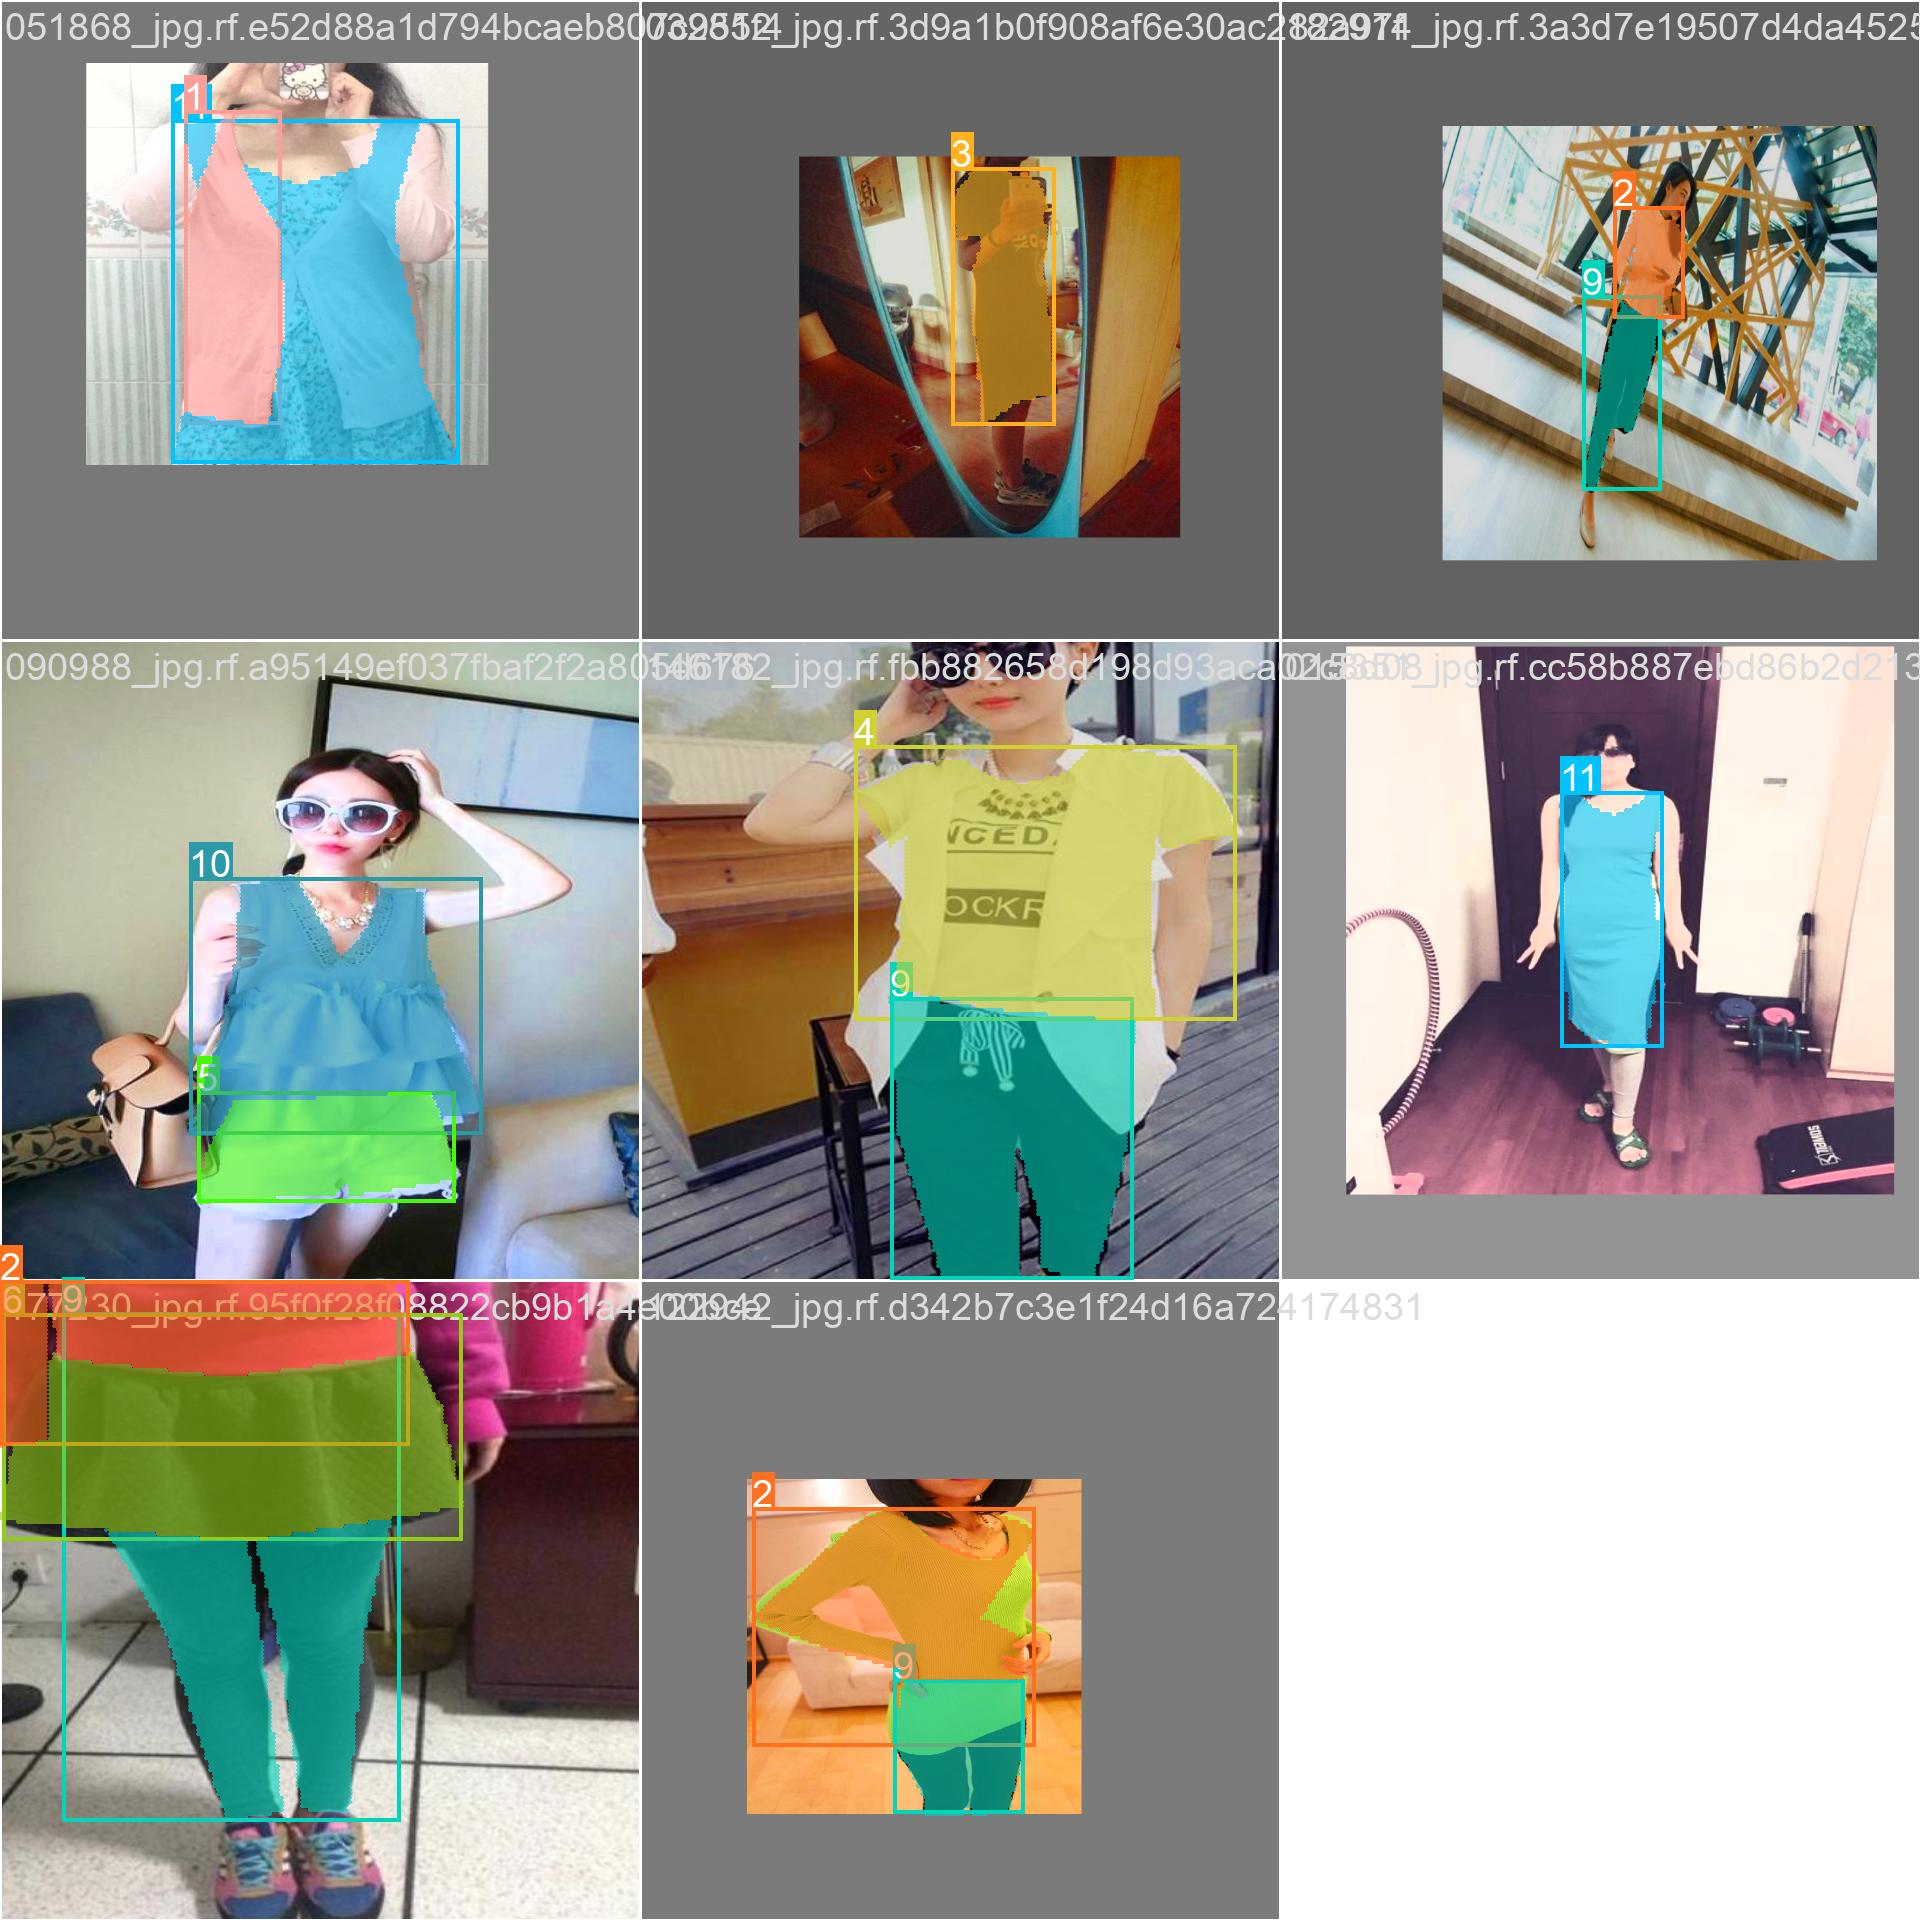

In [ ]:
Image("/content/drive/MyDrive/fashion_data_model/Results/20_epochs-/train_batch4002.jpg" , width =900)

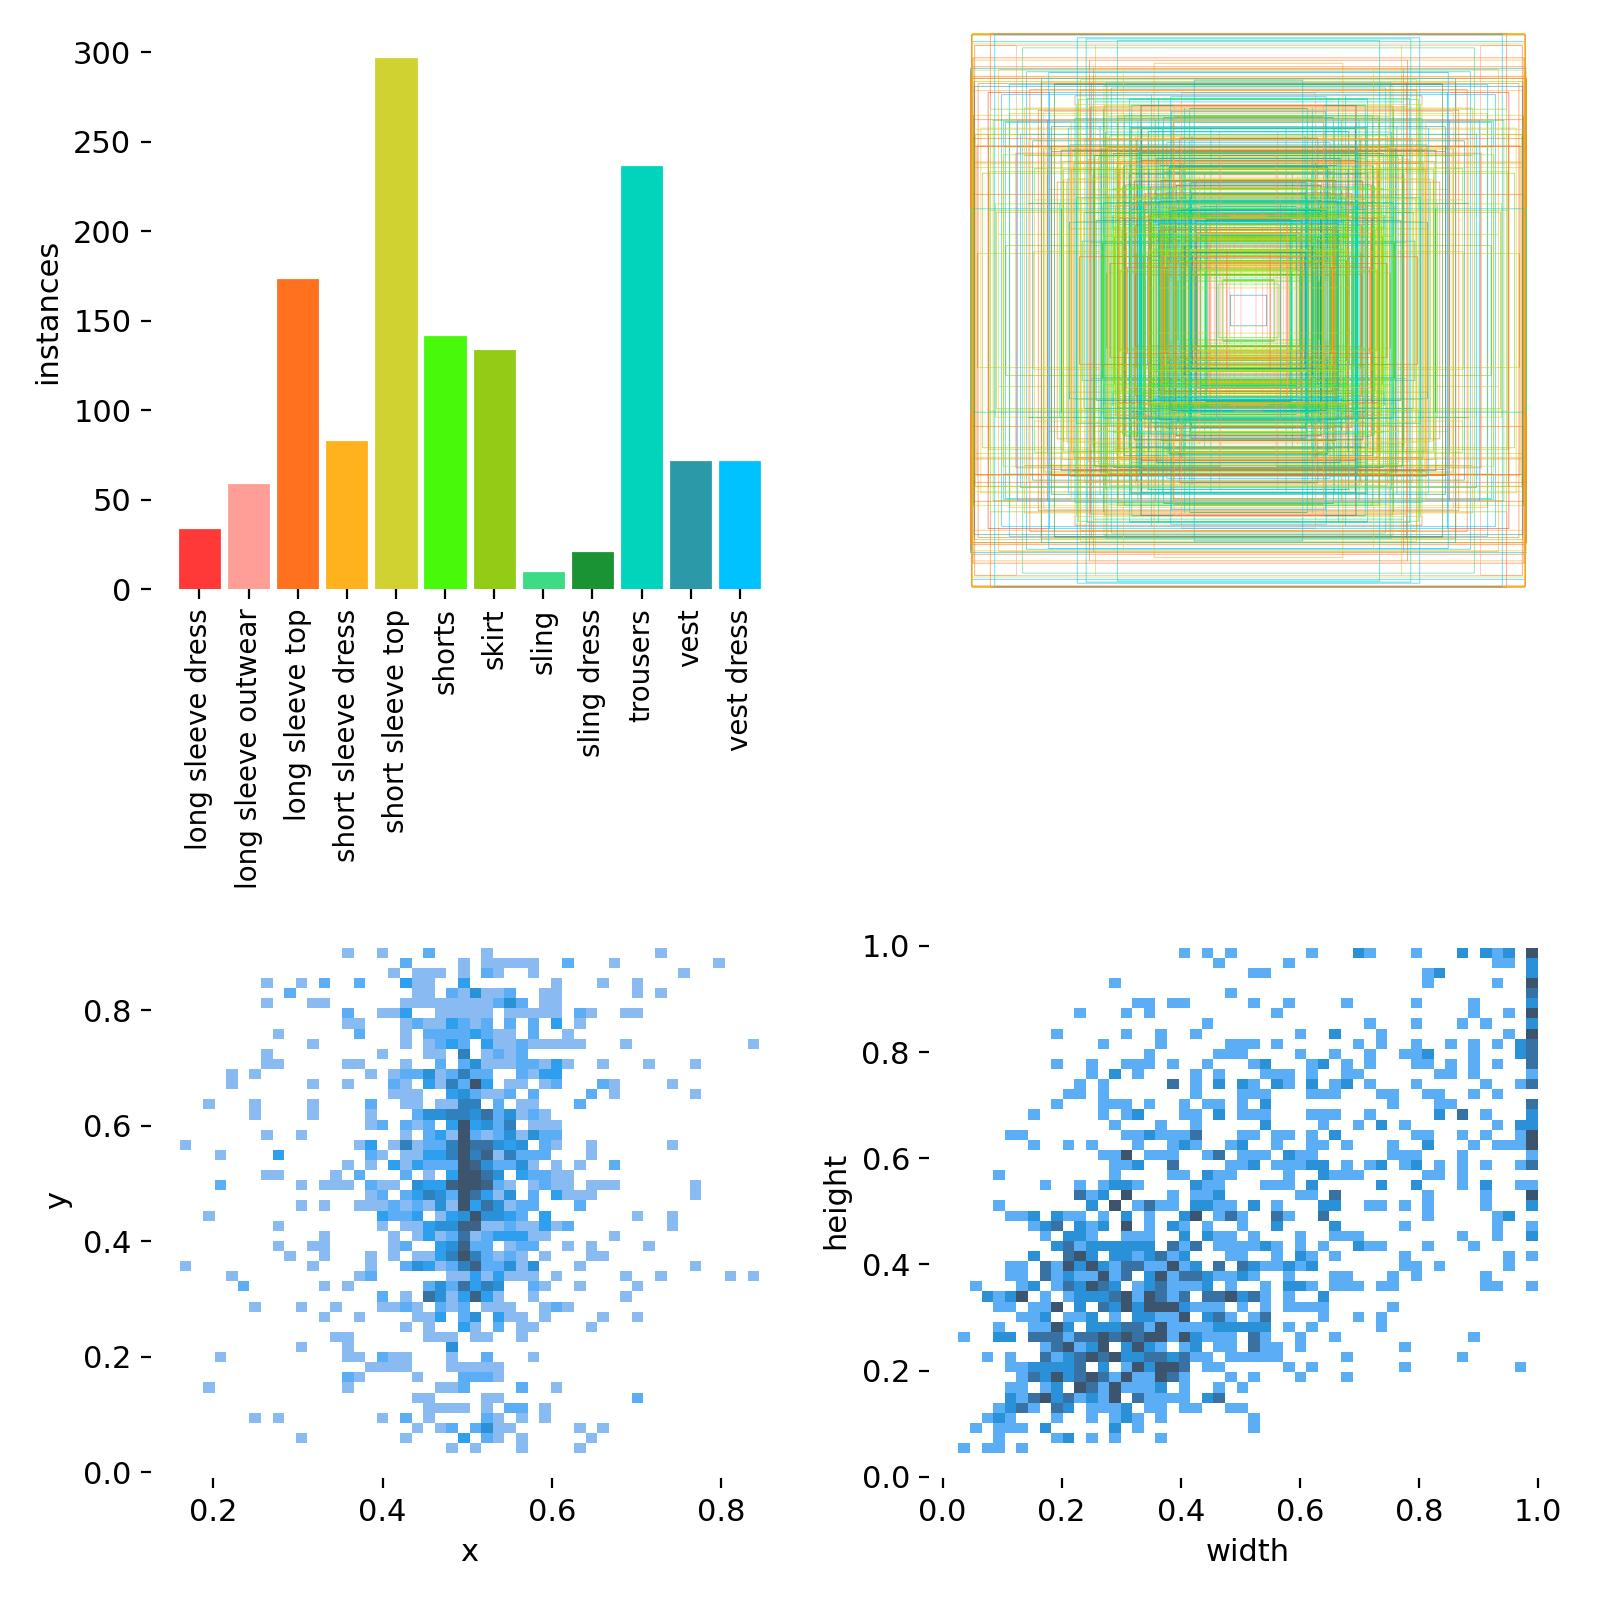

In [ ]:
Image(filename='/content/drive/MyDrive/fashion_data_model/Results/20_epochs-/labels.jpg', width=900)

In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO('/content/drive/MyDrive/fashion_data_model/Results/20_epochs-/weights/best.pt')

# Customize validation settings
validation_results = model.val(data='/content/drive/MyDrive/fashion_data_model/Insynk-1/data.yaml',
                               imgsz=640,
                               batch=8,
                               conf=0.25,
                               iou=0.6,
                               device='0')

Ultralytics YOLOv8.1.39 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-seg summary (fused): 195 layers, 3260404 parameters, 0 gradients, 12.0 GFLOPs


val: Scanning /content/drive/MyDrive/fashion_data_model/Insynk-1/valid/labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


                   all        100        166      0.446      0.484      0.489      0.422      0.444      0.482      0.487      0.374
     long sleeve dress        100          1        0.5          1      0.995      0.995        0.5          1      0.995      0.796
   long sleeve outwear        100          6      0.255      0.167      0.187      0.131      0.255      0.167      0.187      0.112
       long sleeve top        100         19      0.607      0.684      0.592       0.45      0.607      0.684      0.592      0.457
    short sleeve dress        100         11      0.222      0.273      0.347      0.293      0.222      0.273      0.347      0.296
      short sleeve top        100         38      0.669      0.737      0.772      0.676      0.645      0.711      0.739      0.574
                shorts        100         17      0.717      0.745      0.788      0.647      0.717      0.745      0.788      0.625
                 skirt        100         14      0.307      0.412   

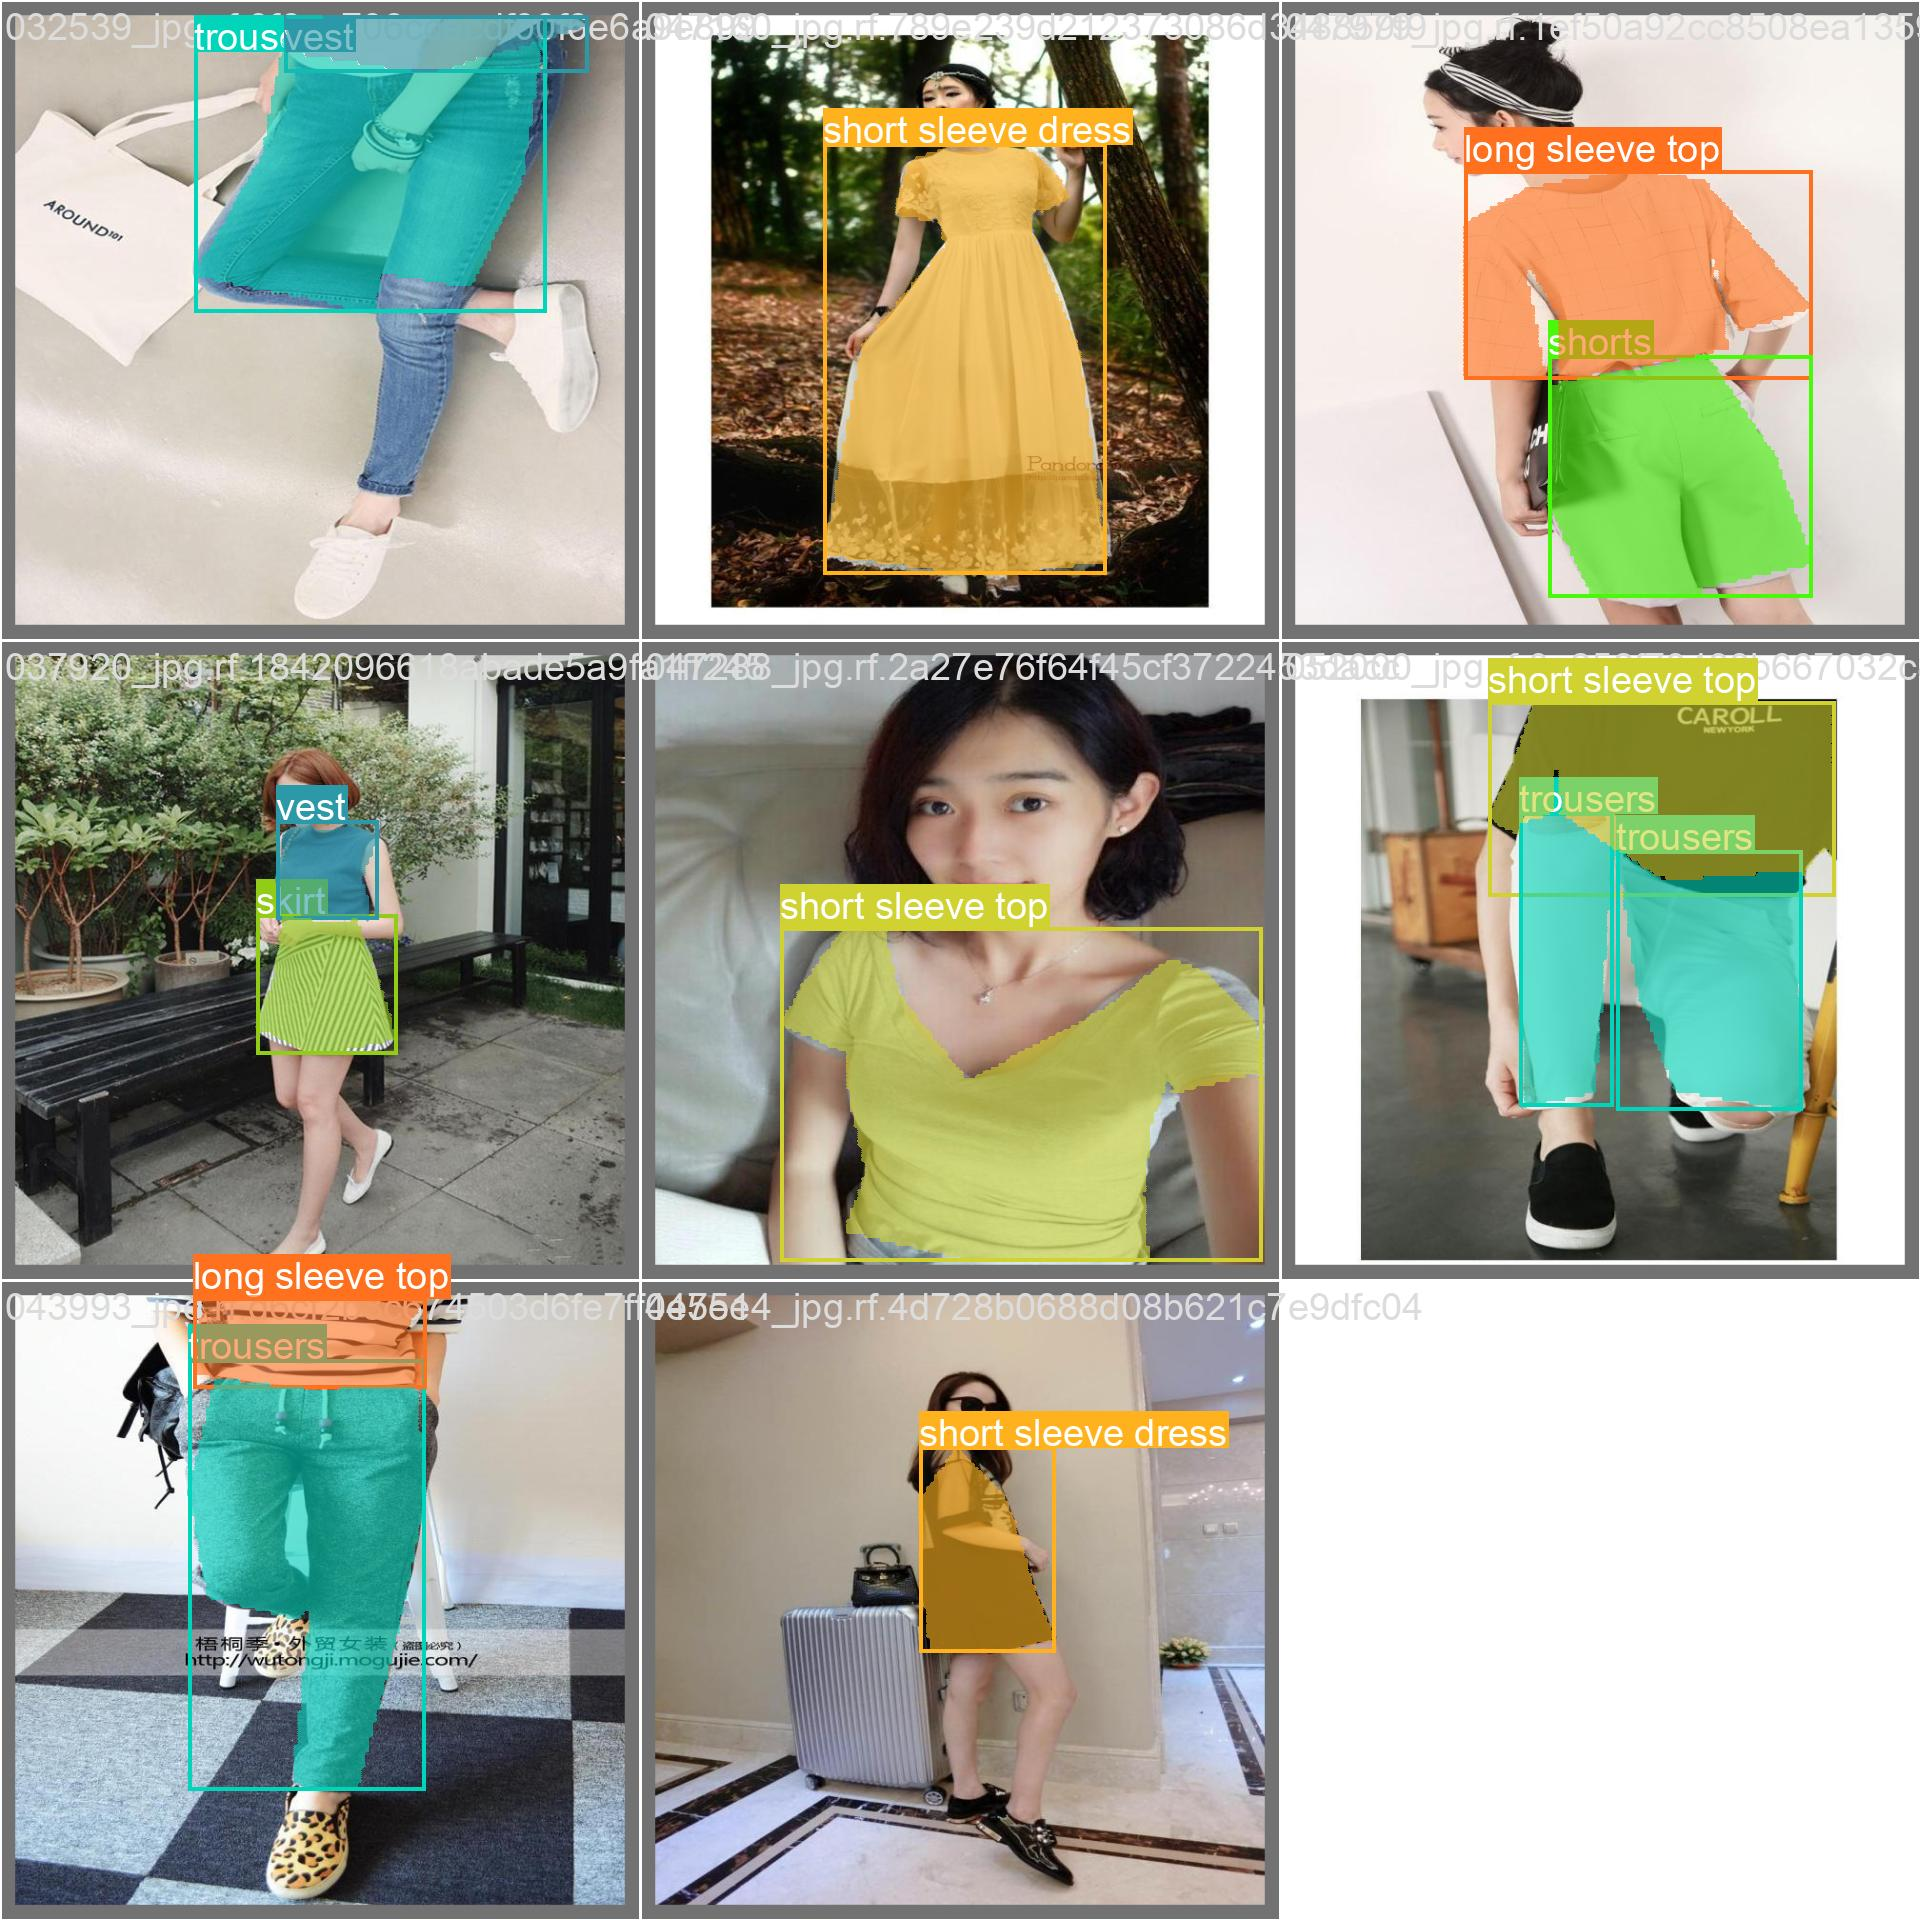

In [ ]:
Image(filename='/content/drive/MyDrive/fashion_data_model/runs/segment/val/val_batch2_labels.jpg', width=900)

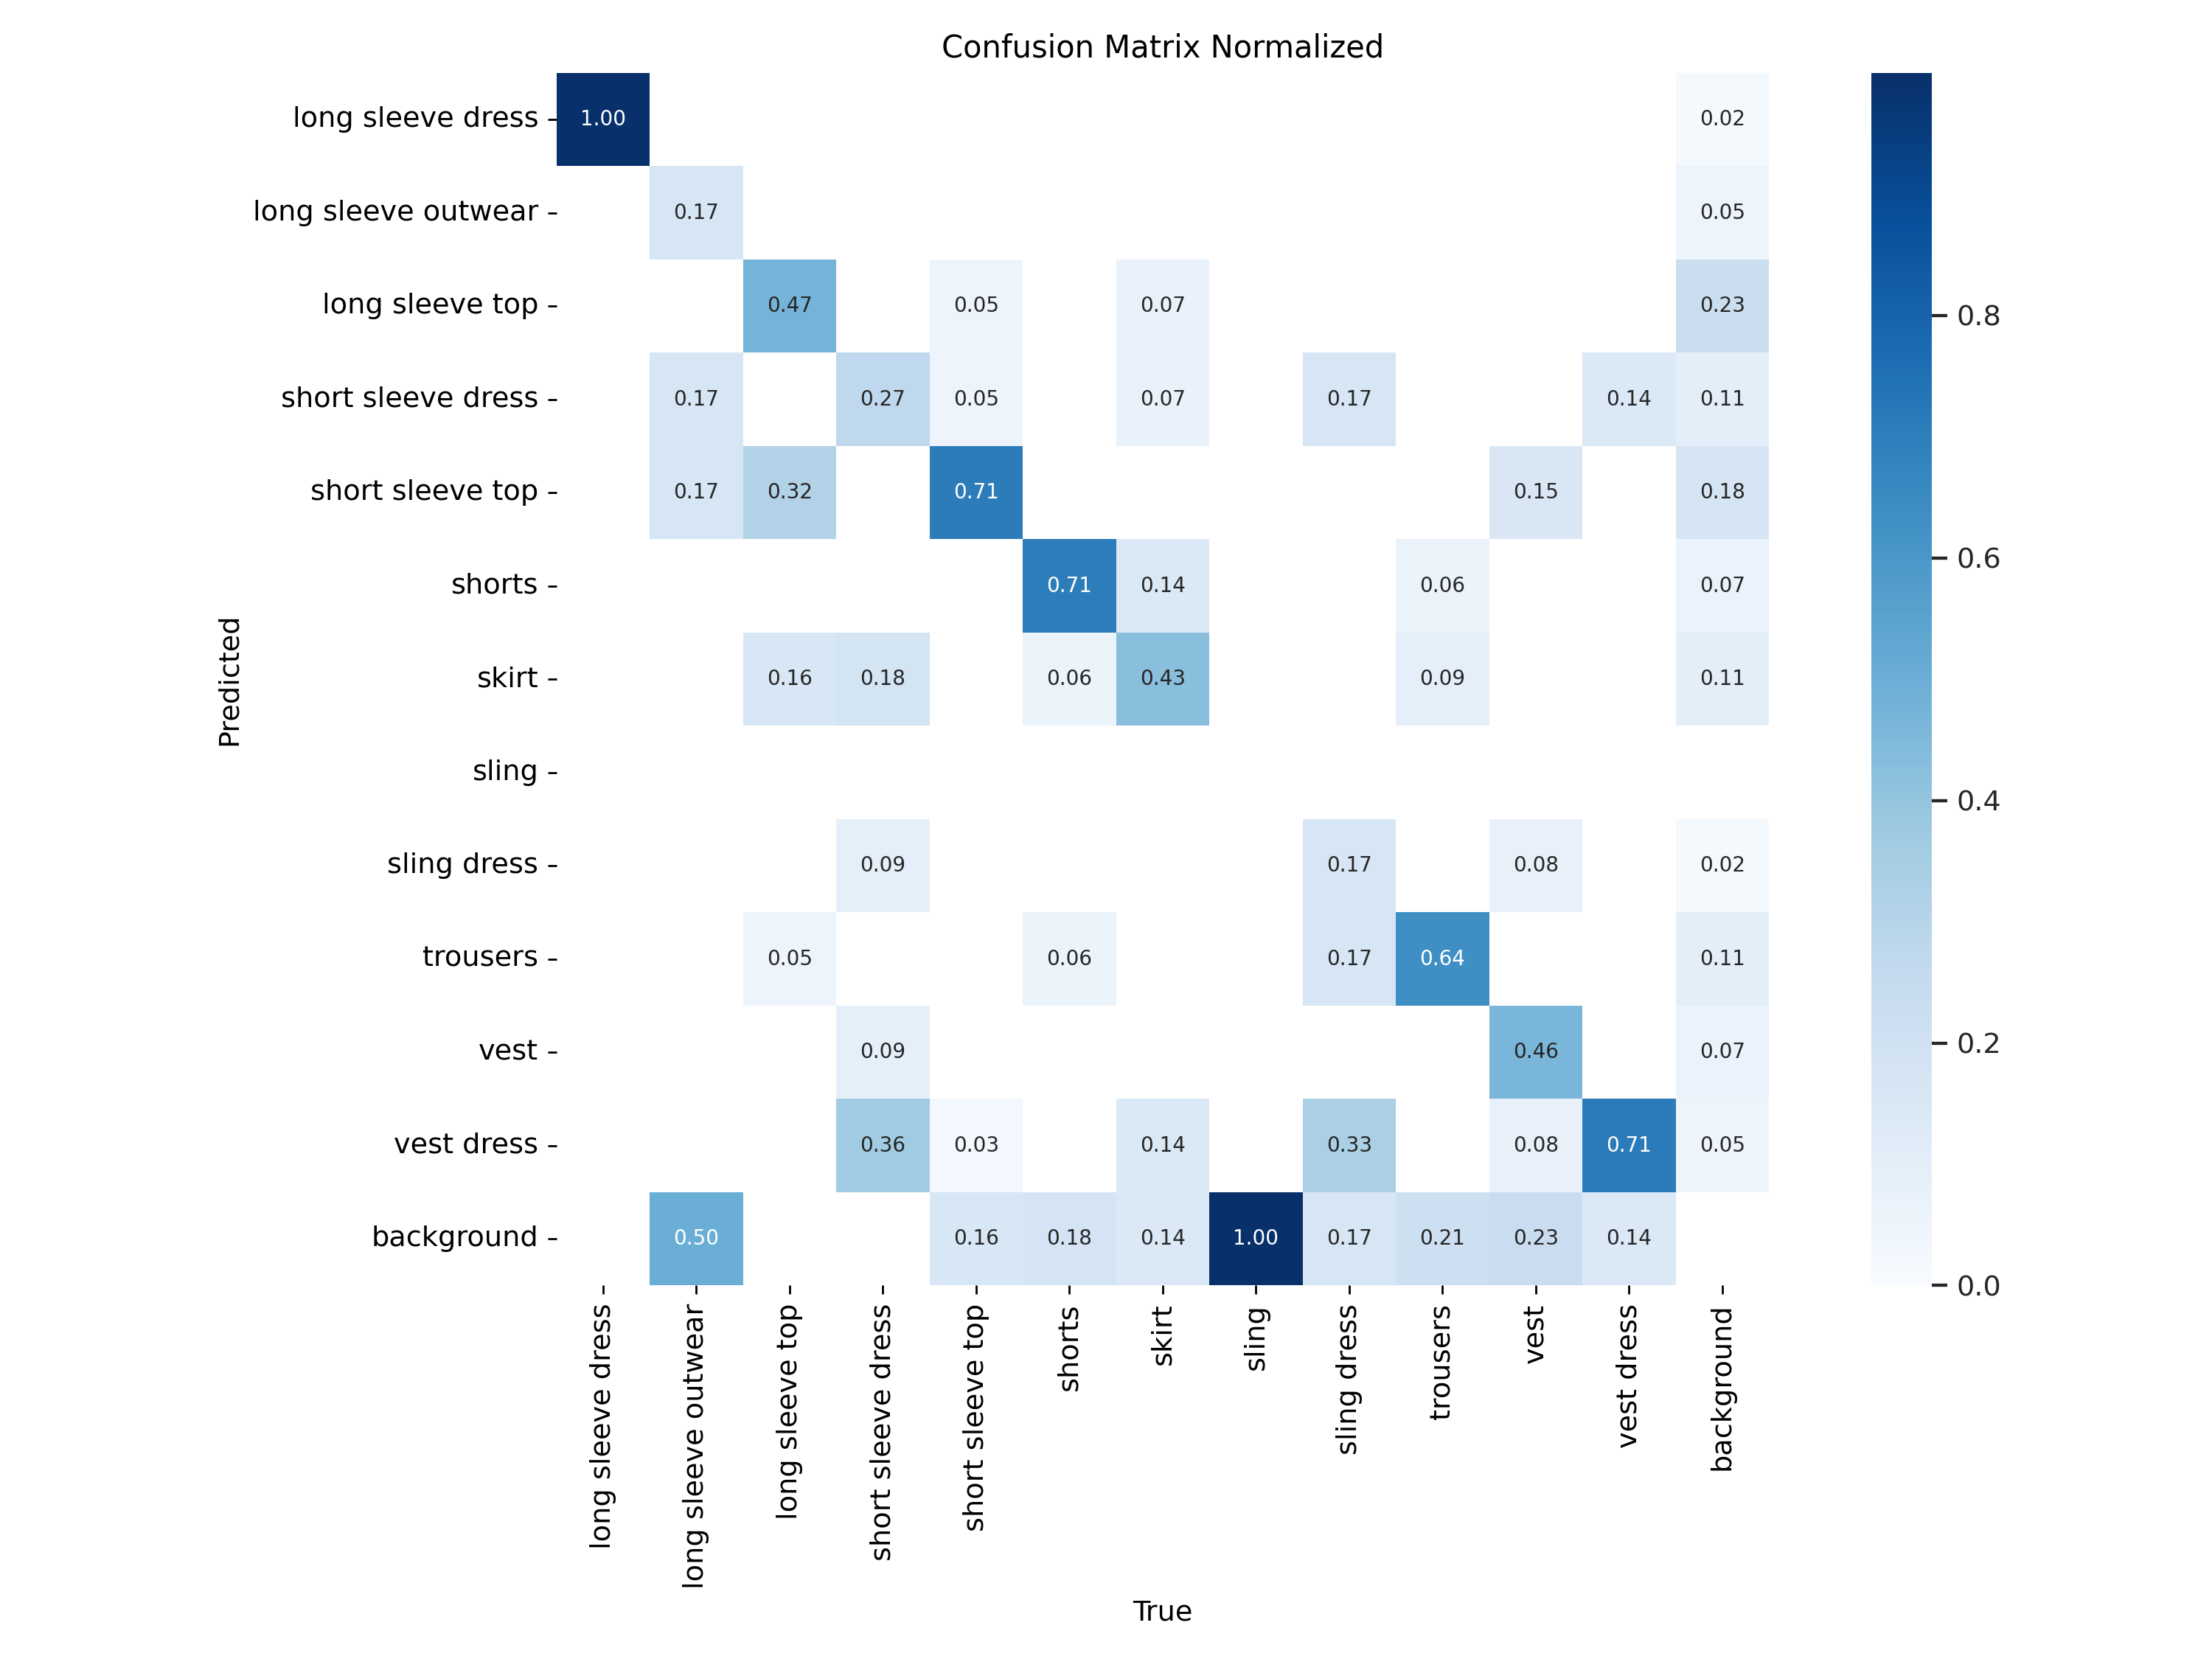

In [ ]:
Image(filename='/content/drive/MyDrive/fashion_data_model/runs/segment/val/confusion_matrix_normalized.png', width=900)

In [ ]:
from ultralytics import YOLO

model = YOLO('/content/drive/MyDrive/fashion_data_model/Results/20_epochs-/weights/best.pt')

model.predict('/content/drive/MyDrive/fashion_data_model/Insynk-1/test/images', save=True, imgsz=640, conf=0.25)


image 1/100 /content/drive/MyDrive/fashion_data_model/Insynk-1/test/images/000731_jpg.rf.9693aadb968941d0503ce4203a9b7a7d.jpg: 640x640 1 short sleeve top, 18.9ms
image 2/100 /content/drive/MyDrive/fashion_data_model/Insynk-1/test/images/000774_jpg.rf.c606caef54fde8c439a98bf78d5027d5.jpg: 640x640 1 shorts, 29.8ms
image 3/100 /content/drive/MyDrive/fashion_data_model/Insynk-1/test/images/006250_jpg.rf.cdf7619d984836658c9b8f1a86f050bf.jpg: 640x640 1 short sleeve dress, 1 trousers, 19.9ms
image 4/100 /content/drive/MyDrive/fashion_data_model/Insynk-1/test/images/007318_jpg.rf.ccc831001485afd4ce5f46087677c5e4.jpg: 640x640 1 short sleeve top, 21.0ms
image 5/100 /content/drive/MyDrive/fashion_data_model/Insynk-1/test/images/009980_jpg.rf.d7cbcf4ae3a41b3300a6e646e6e3dec1.jpg: 640x640 1 trousers, 1 vest, 20.5ms
image 6/100 /content/drive/MyDrive/fashion_data_model/Insynk-1/test/images/010969_jpg.rf.d7ef7f196f915c8b47de0cf1433e2e9b.jpg: 640x640 (no detections), 21.4ms
image 7/100 /content/drive

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: ultralytics.engine.results.Masks object
 names: {0: 'long sleeve dress', 1: 'long sleeve outwear', 2: 'long sleeve top', 3: 'short sleeve dress', 4: 'short sleeve top', 5: 'shorts', 6: 'skirt', 7: 'sling', 8: 'sling dress', 9: 'trousers', 10: 'vest', 11: 'vest dress'}
 obb: None
 orig_img: array([[[ 10,  17,  36],
         [ 10,  17,  36],
         [ 11,  18,  38],
         ...,
         [205, 220, 223],
         [205, 220, 223],
         [205, 220, 223]],
 
        [[  8,  15,  34],
         [  8,  15,  34],
         [  8,  15,  35],
         ...,
         [205, 220, 223],
         [205, 220, 223],
         [205, 220, 223]],
 
        [[  6,  13,  32],
         [  6,  13,  32],
         [  6,  13,  33],
         ...,
         [205, 220, 223],
         [205, 220, 223],
         [205, 220, 223]],
 
        ...,
 
        [[ 95, 126, 177],
         [ 95, 

In [ ]:
from ultralytics import YOLO

model = YOLO('/content/drive/MyDrive/fashion_data_model/Results/20_epochs-/weights/best.pt')

model.predict('/content/drive/MyDrive/fashion_data_model/000017.jpg', save=True, imgsz=640, conf=0.25)


image 1/1 /content/drive/MyDrive/fashion_data_model/000017.jpg: 640x384 1 short sleeve top, 1 trousers, 141.5ms
Speed: 2.5ms preprocess, 141.5ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 384)
Results saved to runs/segment/predict2


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: ultralytics.engine.results.Masks object
 names: {0: 'long sleeve dress', 1: 'long sleeve outwear', 2: 'long sleeve top', 3: 'short sleeve dress', 4: 'short sleeve top', 5: 'shorts', 6: 'skirt', 7: 'sling', 8: 'sling dress', 9: 'trousers', 10: 'vest', 11: 'vest dress'}
 obb: None
 orig_img: array([[[23, 29, 28],
         [23, 29, 28],
         [24, 30, 29],
         ...,
         [25, 32, 27],
         [25, 32, 27],
         [25, 32, 27]],
 
        [[25, 31, 30],
         [25, 31, 30],
         [26, 32, 31],
         ...,
         [26, 33, 28],
         [26, 33, 28],
         [26, 33, 28]],
 
        [[28, 34, 33],
         [28, 34, 33],
         [28, 34, 33],
         ...,
         [27, 34, 31],
         [27, 34, 31],
         [27, 34, 31]],
 
        ...,
 
        [[ 6, 13,  6],
         [ 7, 14,  7],
         [ 8, 14,  9],
         ...,
         [16

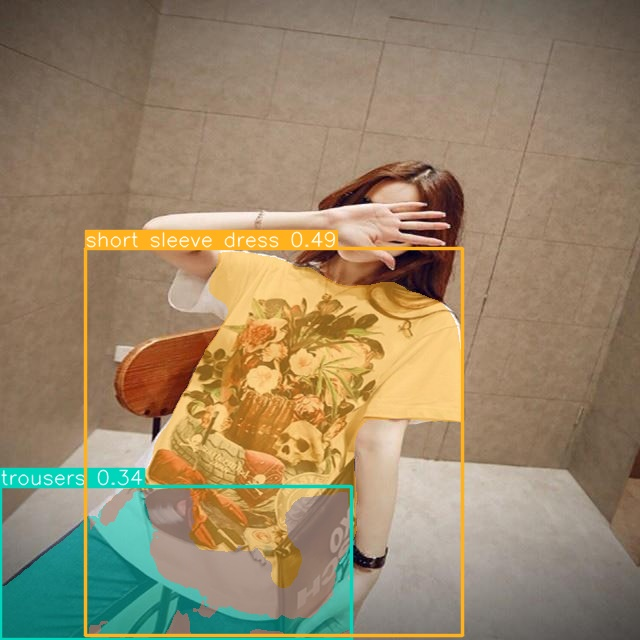

In [ ]:
Image(filename='/content/drive/MyDrive/fashion_data_model/runs/segment/predict/006250_jpg.rf.cdf7619d984836658c9b8f1a86f050bf.jpg', width=400)

In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO('/content/drive/MyDrive/fashion_data_model/Results/20_epochs-/weights/best.pt')  # load a custom trained model

with open('/content/drive/MyDrive/fashion_data_model/config.yaml', 'r') as f:
        config = yaml.safe_load(f)


# Export the model
model.export(format='onnx')

Ultralytics YOLOv8.1.39 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.00GHz)
YOLOv8n-seg summary (fused): 195 layers, 3260404 parameters, 0 gradients, 12.0 GFLOPs

PyTorch: starting from '/content/drive/MyDrive/fashion_data_model/Results/20_epochs-/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) ((1, 48, 8400), (1, 32, 160, 160)) (6.5 MB)

ONNX: starting export with onnx 1.16.0 opset 17...
ONNX: export success ✅ 1.0s, saved as '/content/drive/MyDrive/fashion_data_model/Results/20_epochs-/weights/best.onnx' (12.7 MB)

Export complete (2.8s)
Results saved to /content/drive/MyDrive/fashion_data_model/Results/20_epochs-/weights
Predict:         yolo predict task=segment model=/content/drive/MyDrive/fashion_data_model/Results/20_epochs-/weights/best.onnx imgsz=640  
Validate:        yolo val task=segment model=/content/drive/MyDrive/fashion_data_model/Results/20_epochs-/weights/best.onnx imgsz=640 data=/content/drive/MyDrive/fashion_data_model/Insynk-1/dat

'/content/drive/MyDrive/fashion_data_model/Results/20_epochs-/weights/best.onnx'

In [ ]:
fashion_model = YOLO('/content/drive/MyDrive/fashion_data_model/Results/20_epochs-/weights/best.pt')

In [ ]:
new_image = '/content/drive/MyDrive/fashion_data_model/000020.jpg'
new_results = fashion_model.predict(new_image, conf=0.2)


image 1/1 /content/drive/MyDrive/fashion_data_model/000020.jpg: 640x480 1 short sleeve dress, 85.0ms
Speed: 7.8ms preprocess, 85.0ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 480)


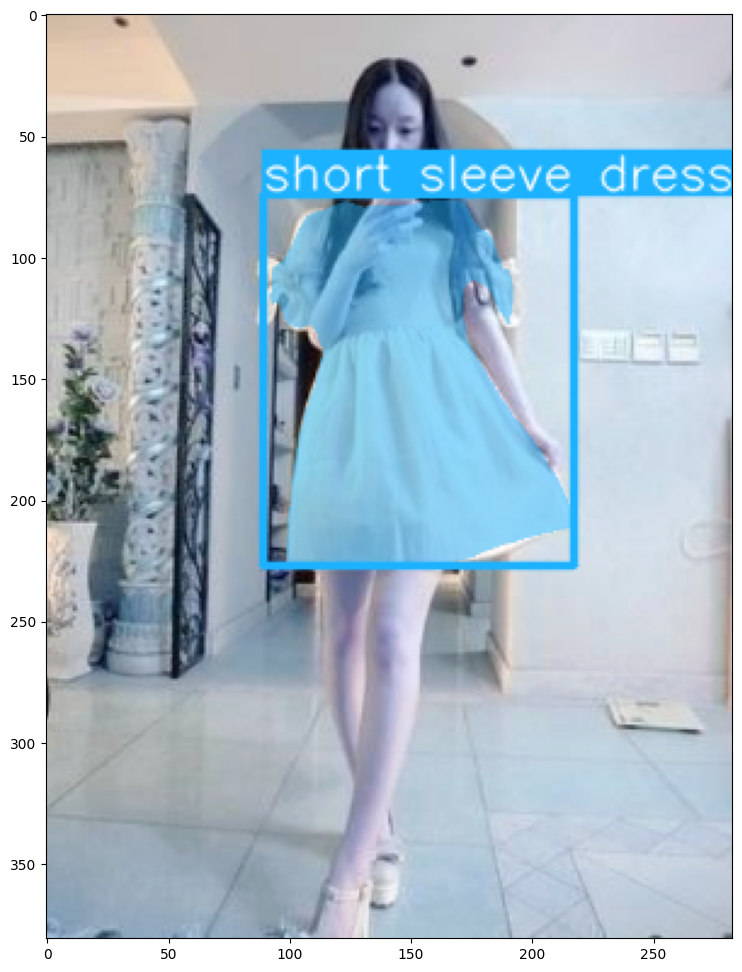

In [ ]:
new_result_array = new_results[0].plot()
plt.figure(figsize=(12, 12))
plt.imshow(new_result_array)

In [ ]:
new_result = new_results[0]   #extracting boundary boxes and segmentaion mask

In [ ]:
new_result

ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: ultralytics.engine.results.Masks object
names: {0: 'long sleeve dress', 1: 'long sleeve outwear', 2: 'long sleeve top', 3: 'short sleeve dress', 4: 'short sleeve top', 5: 'shorts', 6: 'skirt', 7: 'sling', 8: 'sling dress', 9: 'trousers', 10: 'vest', 11: 'vest dress'}
obb: None
orig_img: array([[[207, 186, 165],
        [207, 186, 165],
        [207, 186, 165],
        ...,
        [202, 201, 211],
        [202, 201, 211],
        [202, 201, 211]],

       [[207, 186, 165],
        [207, 186, 165],
        [207, 186, 165],
        ...,
        [202, 201, 211],
        [202, 201, 211],
        [202, 201, 211]],

       [[208, 187, 166],
        [208, 187, 166],
        [208, 187, 166],
        ...,
        [202, 201, 211],
        [202, 201, 211],
        [202, 201, 211]],

       ...,

       [[128, 154, 184],
        [126, 152, 182],
        [118, 144, 174],

In [ ]:
new_result.masks.xyn  #extracting bounding polygon

[array([[     0.5589,     0.20156],
        [     0.5568,     0.20312],
        [    0.54418,     0.20312],
        [    0.54207,     0.20469],
        [    0.53366,     0.20469],
        [    0.53155,     0.20625],
        [    0.51893,     0.20625],
        [    0.51683,     0.20781],
        [    0.49159,     0.20781],
        [    0.48948,     0.20625],
        [    0.47686,     0.20625],
        [    0.47476,     0.20781],
        [    0.46424,     0.20781],
        [    0.46214,     0.20937],
        [    0.46003,     0.20937],
        [    0.45793,     0.20781],
        [    0.45372,     0.20781],
        [    0.45162,     0.20625],
        [    0.44741,     0.20625],
        [    0.44531,     0.20469],
        [     0.4411,     0.20469],
        [      0.439,     0.20312],
        [    0.42848,     0.20312],
        [    0.42637,     0.20469],
        [    0.42427,     0.20469],
        [    0.42217,     0.20625],
        [    0.41796,     0.20625],
        [    0.41586,     0.

In [ ]:
extracted_masks = new_result.masks.data   #extracting segmentation mask

In [ ]:
extracted_masks.shape

torch.Size([1, 640, 480])

In [ ]:
masks_array = extracted_masks.cpu().numpy()

In [ ]:
masks_array

array([[[          0,           0,           0, ...,           0,           0,           0],
        [          0,           0,           0, ...,           0,           0,           0],
        [          0,           0,           0, ...,           0,           0,           0],
        ...,
        [          0,           0,           0, ...,           0,           0,           0],
        [          0,           0,           0, ...,           0,           0,           0],
        [          0,           0,           0, ...,           0,           0,           0]]], dtype=float32)

In [ ]:
class_names = new_result.names.values()
class_names

dict_values(['long sleeve dress', 'long sleeve outwear', 'long sleeve top', 'short sleeve dress', 'short sleeve top', 'shorts', 'skirt', 'sling', 'sling dress', 'trousers', 'vest', 'vest dress'])

In [ ]:
# Extract the boxes, which likely contain class IDs
detected_boxes = new_result.boxes.data
# Extract class IDs from the detected boxes
class_labels = detected_boxes[:, -1].int().tolist()
# Initialize a dictionary to hold masks by class
masks_by_class = {name: [] for name in new_result.names.values()}

# Iterate through the masks and class labels
for mask, class_id in zip(extracted_masks, class_labels):
    class_name = new_result.names[class_id]  # Map class ID to class name
    masks_by_class[class_name].append(mask.cpu().numpy())

In [ ]:
for class_name, masks in masks_by_class.items():
    print(f"Class Name: {class_name}, Number of Masks: {len(masks)}")

Class Name: long sleeve dress, Number of Masks: 0
Class Name: long sleeve outwear, Number of Masks: 0
Class Name: long sleeve top, Number of Masks: 0
Class Name: short sleeve dress, Number of Masks: 1
Class Name: short sleeve top, Number of Masks: 0
Class Name: shorts, Number of Masks: 0
Class Name: skirt, Number of Masks: 0
Class Name: sling, Number of Masks: 0
Class Name: sling dress, Number of Masks: 0
Class Name: trousers, Number of Masks: 0
Class Name: vest, Number of Masks: 0
Class Name: vest dress, Number of Masks: 0


In [ ]:
shortsleeve_granule_masks = masks_by_class['short sleeve dress']

In [ ]:
orig_img = new_result.orig_img

In [ ]:
orig_img.shape

(640, 480, 3)

In [ ]:
import cv2
import numpy as np

desired_height = 640
desired_width = 480

# Resize the image to the desired shape
orig_img = cv2.resize(orig_img, (desired_width, desired_height))


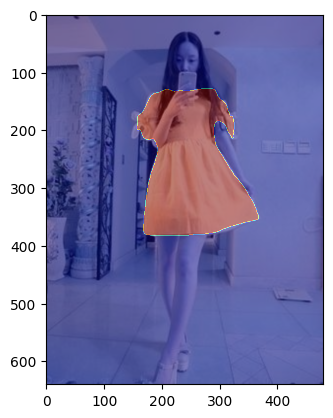

In [ ]:
# Display the original image
plt.imshow(orig_img, cmap='gray')

# Overlay the mask with some transparency
plt.imshow(shortsleeve_granule_masks[0], cmap='jet', alpha=0.5)
plt.axis('on')
plt.show()

In [ ]:
import pandas as pd
from skimage.measure import regionprops

props_list = []

for class_name, masks in masks_by_class.items():
    for mask in masks:
        mask = mask.astype(int)

        props = regionprops(mask)

        for prop in props:
            area = prop.area
            perimeter = prop.perimeter

            props_list.append({'Class Name': class_name, 'Area': area, 'Perimeter': perimeter})

props_df = pd.DataFrame(props_list)

props_df.to_csv('/content/drive/MyDrive/fashion_data_model/YOLOv8_object_properties.csv', index=False)

In [ ]:
props_df

,Class Name,Area,Perimeter
0,short sleeve dress,36707,972.523953


In [ ]:
import seaborn as sns

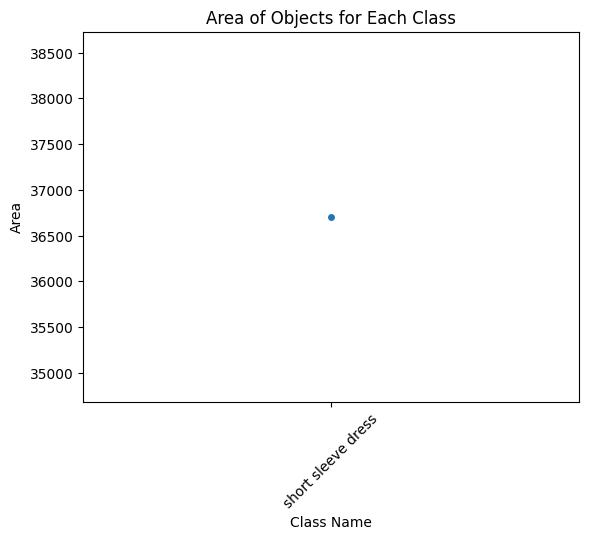

In [ ]:
sns.swarmplot(x='Class Name', y='Area', data=props_df)

plt.xlabel('Class Name')
plt.ylabel('Area')
plt.title('Area of Objects for Each Class')

plt.xticks(rotation=45)

plt.show()